#### Hub-Based Vehicle Scheduling for Home Improvement Stores

In this project, you will tackle a real-world scheduling problem faced by logistics teams for home improvement stores. You are provided with a dataset containing the latitude and longitude coordinates of multiple store locations across a region. The objective is to strategically determine a set of hubs and plan efficient routes from those hubs to serve other store locations, ensuring that logistical constraints are met.

#### Project Scenario
You are tasked with selecting a subset of the store locations to serve as hubs. Each hub acts as the *depot* for a fleet of vehicles that will regularly visit other store locations. The challenge is to select the optimal locations for the hubs and design routes for the vehicles in such a way that no individual vehicle route exceeds 400 miles, including the return trip to its assigned hub.

#### Dataset and Tools
- **Store Location Dataset**: Includes latitude and longitude coordinates for all stores.
 **road distance Dataset**: Includes road trip distance between locations

#### Goals and Tasks
Your primary goals are as follows:

1. **Hub Selection**: Select a subset of `n` locations to serve as hubs. You will consider three different scenarios where the number of hubs (`n`) is 15, 20, and 25.

2. **Route Determination**: For each hub, determine the set of routes from the hub to other store locations. Ensure that each route is feasible, meaning that no route exceeds a round-trip distance of 400 miles.

3. **Analysis and Reporting**: Report on the total travel distance across all routes and identify any routes that exceed the 400-mile limit. Your analysis should cover each of the three scenarios for the number of hubs (`n = 15, 20, 25`).

#### Deliverables
- **Route Planning Strategy**: Describe your approach to selecting hubs and planning routes.
- **Route and Hub Analysis**: Present a comparison of the total travel distance and the number of route violations for each scenario (`n = 15, 20, 25`).
- **Code and Documentation**: Your solution should be implemented in Python, using Jupyter Notebook to demonstrate your approach. Include markdown cells to explain your process and the logic behind your decisions.
- **Presentation**: A brief presentation summarizing your methodology, findings, and challenges encountered.

#### Evaluation Criteria
- **Correctness**: Adherence to the 400-mile route limit and appropriate hub selection.
- **Optimization**: How effectively you minimize total travel distance and route violations.
- **Clarity**: Clear documentation, explanation of your methods, and interpretation of results.

#### Teamwork
Students will be able to work in teams of up to three. Collaborate effectively to divide tasks and ensure a thorough exploration of the problem.

#### Use of Generative AI
Students are encouraged to use generative AI tools. However, you must disclose which tools you used and how you used them.

#### Data Permissions
You **do not** have permission to upload the data to any tool or to post the data on any publicly accessible repository.

The following code block imports some libraries necessary to load the data and perform the distance computations.

<p style="text-align:center; font-weight:bold;">Process</p>

- Final Project submission for Luke Jones and Madison Brown 522-001
- Chat GPT was used to help create functions and torubleshoot problems, but the ideas were all our own
- We chose to focus on minimizing the distance over limiting violations

In [60]:
import os

os.environ["OMP_NUM_THREADS"] = "2"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from sklearn.cluster import KMeans

sns.set_style('whitegrid')

The following code block loads the data

In [61]:
# Load all data and removes all columns from road distance that is not needed

store_data = pd.read_csv(
    'store_data.csv'
).reset_index()
store_data['index'] = 'L' + (store_data['index'] + 1).astype(str)
store_data = store_data.rename(columns={'index': 'location'})

road_distances = pd.read_csv(
    'road_distances.csv'
).reset_index()
road_distances = road_distances.loc[:, ['store1','store2', 'distance']]

The following code block uses a scatterplot to visualize the locations.

<Axes: xlabel='longitude', ylabel='latitude'>

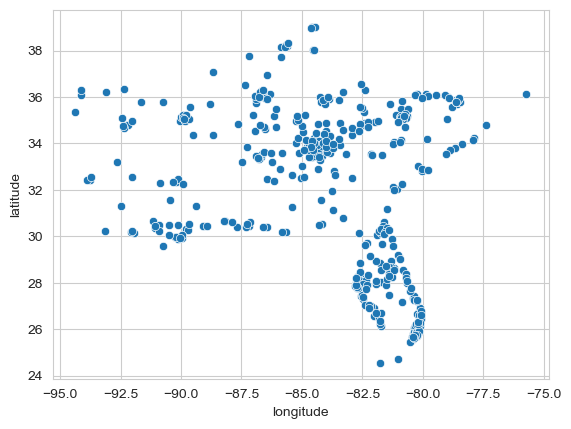

In [62]:
sns.scatterplot(
    store_data,
    x='longitude',
    y='latitude',
)


<p style="text-align:center; font-weight:bold;">Assumptions</p>

- The trucks used in the netwrok have enough capacity to meet all demand of the stores on their routes
- The distances provided in road_distances are correct and while not shown, any graphical representation exists to show the locations that are served, and not the actual driving routes the trucks would take.
- The goal is to minimize the total distance of all routes while adhering to the provided maximum distance and number of nodes

<p style="text-align:center; font-weight:bold;">Code</p>

This block defines the road distances into a dictionary for easier access and filtering

In [63]:
def distance_matrix_dict_maker(road_distances):
    
    distance_matrix_dict = {}
    for origin, destination, distance in road_distances.values:
        distance_matrix_dict[(origin, destination)] = distance
    
    return distance_matrix_dict


This block uses the kmeans clustering algorithm to cluster all the stores into a number of clusters equal to the number of hubs. This is to make choosing hubs and the possible routes much easier and realtively good due to geographic proximity.

In [64]:
def cluster_locations(number_of_hubs, store_data, random):

    coords = store_data[['latitude', 'longitude']]
    # Apply  clustering
    kmeans = KMeans(n_clusters=number_of_hubs, random_state=random)

    
    store_data['cluster'] = kmeans.fit_predict(coords)

    return store_data


This block calculates the clark wright savings for all locations to one another within a hub. Clarck Wright is a pretty good algorithm and is appropriate for the situation hence its implementations.

In [65]:
def savings_calculater(location_names, hub, distance_matrix):
    savings = []
    
    for location1 in location_names:
        for location2 in location_names:
            if location1 == location2:  # Skip the case where location1 == location2
                continue  # No savings for self-routing
            
            if location1 < location2:
                sij = (
                    distance_matrix[(hub, location1)] 
                    + distance_matrix[(hub, location2)] 
                    - distance_matrix[(location1, location2)]
                )
                savings.append((location1, location2, sij))
            
    savings = sorted(savings, key=lambda x: x[2], reverse=True)

    return savings


This block will calculate the route distance of any given route.

In [66]:
def calculate_route_distance(route, distance_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        loc1, loc2 = route[i], route[i + 1]
        
        # Ensure that the distance is bidirectional (check both (loc1, loc2) and (loc2, loc1))
        if (loc1, loc2) in distance_matrix:
            total_distance += distance_matrix[(loc1, loc2)]
        elif (loc2, loc1) in distance_matrix:
            total_distance += distance_matrix[(loc2, loc1)]
        else:
            raise ValueError(f"Distance between {loc1} and {loc2} not found in the distance matrix.")
    
    return total_distance


This code block creates all the initial hub -> store -> hub routes to use in Clark Wright

In [67]:
def create_initial_routes(all_locations, hub):
    # Initialize each route so that it starts and ends at the hub
    routes = {f'R{idx}': [hub, location, hub] for idx, location in enumerate(all_locations, 1)}
    return routes

This code block runs a nearest neighbor travelling salesman on each route to improve it and reduce overall distance. This is to decrease the distance of each route thus reducing total distance

In [68]:
def tsp_route_optimization(route, distance_matrix, max_distance, fixed_start_end):
    
    fixed_start, fixed_end = fixed_start_end
    
    # Get the sub-route to optimize (excluding the fixed start and end locations)
    sub_route = [loc for loc in route if loc != fixed_start and loc != fixed_end]

    # If there is only one location to visit, return the original route
    if len(sub_route) <= 1:
        return route

    # Start with the fixed start location
    current_location = fixed_start
    optimized_route = [current_location]
    unvisited_locations = sub_route.copy()

    # Nearest neighbor algorithm: visit nearest unvisited location until all are visited
    while unvisited_locations:
        # Find the nearest unvisited location
        nearest_location = min(unvisited_locations, key=lambda loc: distance_matrix.get((current_location, loc), float('inf')))
        
        # Add the nearest location to the route
        optimized_route.append(nearest_location)
        
        # Update the current location and remove the visited location from the unvisited list
        current_location = nearest_location
        unvisited_locations.remove(nearest_location)

    # End with the fixed end location (hub)
    optimized_route.append(fixed_end)

    # Ensure the distance of the optimized route is within the max_distance
    route_distance = calculate_route_distance(optimized_route, distance_matrix)
    if route_distance <= max_distance:
        return optimized_route
    else:
        # If the route exceeds the max distance, return the original route
        return route



This code block actually performs the Clark Wright savings algorithm. It utilizes the above TSP to take the best route possible from combining two different ones and only keeps it if it will not violate the distance contraint. This way more routes can be combined and it will reduce the distance of any routes that cannot be combined. By running the TSP before distance calculations a better route can be created

In [69]:
def combine_routes_using_savings(routes, savings, distance_matrix, max_distance, hub, hub_number):
    location_to_route = {}

    # Initialize the location_to_route mapping
    for route_name, route_locations in routes.items():
        for route_location in route_locations:
            location_to_route[route_location] = route_name

    # Process savings and combine routes
    for location1, location2, sij in savings:
        route_name1 = location_to_route[location1]
        route_name2 = location_to_route[location2]
        
        if route_name1 != route_name2:
            # Combine the routes if possible, excluding hub from combination
            potential_combined_route = list(routes[route_name1][1:-1]) + list(routes[route_name2][1:-1])  # Exclude hub
            
            # Ensure the new route doesn't exceed max distance
            combined_route = [hub] + potential_combined_route + [hub]
            
            if calculate_route_distance(combined_route, distance_matrix) <= max_distance:
                # Remove the second route and update the first route
                routes[route_name1] = combined_route
                routes.pop(route_name2)

                # Rebuild the location_to_route dictionary after combining routes
                location_to_route = {}
                for route_name, route_locations in routes.items():
                    for route_location in route_locations:
                        location_to_route[route_location] = route_name

    # Initialize the final structure for routes grouped by hub number
    final_routes = {}
    route_idx = 1
    hub_routes = []  # List to store routes for each hub

    # Add the hub to the list of routes, along with their distances
    for route_name, route_locations in routes.items():
        # Ensure each route starts and ends at the hub
        if route_locations[0] != hub:
            route_locations = [hub] + route_locations  # Add hub to the start if missing
        if route_locations[-1] != hub:
            route_locations = route_locations + [hub]  # Add hub to the end if missing

        # Optimize the route using Nearest Neighbor
        optimized_route = tsp_route_optimization(route_locations, distance_matrix, max_distance, (route_locations[0], route_locations[-1]))

        # Calculate the total distance of the optimized route
        route_distance = calculate_route_distance(optimized_route, distance_matrix)

        # Store the optimized route (without hub field in sub-dictionary) with the distance
        hub_routes.append({
            'Route Name': f'R{route_idx}',
            'Route': optimized_route,
            'Distance': route_distance
        })
        route_idx += 1

    # Store the hub and its associated routes in the final dictionary
    final_routes[f'Hub {hub_number}'] = hub_routes  # Store the hub and routes in the same list, no hub name inside routes

    return final_routes


This code block runs through every store within a cluster and chooses the best hub with the goal of minimizing the total distance across all routes from that hub. This way within each cluster the best hub is chosen and further reduces the total distance of all the routes

In [70]:
def find_best_hub_and_routes(all_locations, distance_matrix, max_distance):
    best_total_distance = float('inf')  # Start with an infinitely large number
    best_hub = None
    best_routes = None

    # Iterate through all locations in all_locations as potential hubs
    for hub_number, hub in enumerate(all_locations, 1):
        # Create initial routes with hub at start and end
        routes = create_initial_routes(all_locations, hub)

        # Calculate savings based on the current locations and the hub
        savings = savings_calculater(all_locations, hub, distance_matrix)

        # Combine routes based on savings while ensuring no route exceeds the max distance
        final_routes = combine_routes_using_savings(routes, savings, distance_matrix, max_distance, hub, hub_number)

        # Filter out routes with distance of 0 because they don't actually exist
        filtered_routes = [route for route in final_routes[f'Hub {hub_number}'] if route['Distance'] > 0]

        # Calculate the total distance for this hub's routes
        total_distance = sum(route['Distance'] for route in filtered_routes)  # Sum of distances for all routes

        # Update the best hub and routes if this hub gives a better total distance
        if total_distance < best_total_distance:
            best_total_distance = total_distance
            best_hub = hub
            best_routes = filtered_routes

    # Rename the routes (R1, R2, etc.)
    for idx, route in enumerate(best_routes, 1):
        route['Route Name'] = f'R{idx}'

    # Return the best hub and its corresponding routes
    return {
        'Hub': best_hub,
        'Total Distance': best_total_distance,
        'Routes': best_routes
    }


This the code that will call all of the other functions to generate the distribution network.
It makes the distances first and clusters, before checking every location within a cluster and choosing the one with the lowest overall distance to serve all stores within the route.

In [71]:
def network_generator(number_of_hubs, max_distance, random):
    # Initialize the final_routes dictionary, which will also include metadata
    final_routes = {
        'Random State': random,
        'Number of Hubs': number_of_hubs,
        'Total Distance of Network': 0,  # Placeholder for total distance across all clusters
        'Total Number of Routes': 0,
        'Clusters': {}  # This will hold the results for each cluster
    }

    # Initialize the random state
    random = 78
    distance_matrix = distance_matrix_dict_maker(road_distances)
    clustered_data = cluster_locations(number_of_hubs, store_data, random)
   
    # Initialize a variable to track the total distance across all clusters
    total_distance_across_network = 0
    total_number_of_routes_across_network = 0  # Initialize a counter for total routes

    # Iterate over each hub to find best routes
    for i in range(number_of_hubs):
        cluster = i
        current_cluster_data = clustered_data[clustered_data['cluster'] == cluster]
        all_locations = current_cluster_data['location'].unique().tolist()

        # Find best hub and routes for the current cluster
        cluster_result = find_best_hub_and_routes(all_locations, distance_matrix, max_distance)

        # Calculate the total distance for the current cluster's routes
        total_cluster_distance = sum(route['Distance'] for route in cluster_result['Routes'])
        
        # Update the total distance across all clusters
        total_distance_across_network += total_cluster_distance

        # Count the total number of routes in the current cluster
        total_number_of_routes = len(cluster_result['Routes'])  # Count routes in the current cluster

        # Update the total number of routes across all clusters
        total_number_of_routes_across_network += total_number_of_routes

        # Store the cluster result along with the total distance and route count in the final dictionary
        final_routes['Clusters'][cluster] = {
            'Hub': cluster_result['Hub'],
            'Total Distance': total_cluster_distance,
            'Routes': cluster_result['Routes'],
            'Total Number of Routes': total_number_of_routes
        }

    # After processing all clusters, update the total distance and route count across all clusters
    final_routes['Total Distance of Network'] = total_distance_across_network
    final_routes['Total Number of Routes'] = total_number_of_routes_across_network

    return final_routes


<p style="text-align:center; font-weight:bold;">Final Code Block</p>

This is the final block that will run all the prior functions based on the parameters set.
The parameters are:
- number_of_hubs: The number of hubs or stores to serve as distribution centers
- max_distance: the maximim round trip distance in miles
- ni_nonimproving: the number of nonimproving iterations to run before returning a final solution. THis has limited effect due to Kmeans algorithm

It will print out the best solutions distance. Each iterations takes about 15 seconds to run.

In [72]:
# Set parameters here
number_of_hubs = 20 # Number of stores to act as hubs
max_distance = 400 # Max round trip distance
ni_nonimproving = 1 # Number of nonimproving iterations to run. I ran them for all quite a few, but it doesn't make a difference since Kmeans converges so the seed has little effect in this case

best_distance = float('inf')
np.random.seed(522001)
iteration = 0
count = 0
progress = []

while iteration < ni_nonimproving:
    iteration += 1
    count += 1
    
    random = np.random.randint(0, 522001)
    incumbent_network = network_generator(number_of_hubs, max_distance, random)
    incumbent_distance = incumbent_network['Total Distance of Network']

    if incumbent_distance < best_distance:
        final_network = incumbent_network
        best_distance = incumbent_distance
        iteration = 0
    progress.append({'Iteration': count, 'Best': incumbent_distance})

print('Best Solution Found with Distance:', best_distance)


Best Solution Found with Distance: 14956.2041759979


<p style="text-align:center; font-weight:bold;">Print out the final network dictionary</p>

This inclues:
- The Random Seed used in the kmeans clustering
- The number of hubs used
- The total DIstance of Network
- The clusters or hubs along with the store chosen as the hub for that cluster of stores
- The total distance of routes on that hub
- Each route and the route distance 

In [73]:
print(final_network)

{'Random State': 447939, 'Number of Hubs': 20, 'Total Distance of Network': 14956.2041759979, 'Total Number of Routes': 49, 'Clusters': {0: {'Hub': 'L24', 'Total Distance': 978.4872673701, 'Routes': [{'Route Name': 'R1', 'Route': ['L24', 'L11', 'L22', 'L18', 'L14', 'L16', 'L10', 'L24'], 'Distance': 356.3052539409}, {'Route Name': 'R2', 'Route': ['L24', 'L21', 'L8', 'L25', 'L7', 'L4', 'L9', 'L3', 'L24'], 'Distance': 397.396580308}, {'Route Name': 'R3', 'Route': ['L24', 'L12', 'L5', 'L19', 'L26', 'L20', 'L23', 'L24'], 'Distance': 224.7854331212}], 'Total Number of Routes': 3}, 1: {'Hub': 'L79', 'Total Distance': 1054.1045141183, 'Routes': [{'Route Name': 'R1', 'Route': ['L79', 'L89', 'L56', 'L125', 'L141', 'L150', 'L133', 'L86', 'L93', 'L74', 'L164', 'L132', 'L62', 'L117', 'L144', 'L163', 'L174', 'L79'], 'Distance': 318.4838924613}, {'Route Name': 'R2', 'Route': ['L79', 'L137', 'L106', 'L153', 'L156', 'L167', 'L122', 'L169', 'L81', 'L187', 'L127', 'L84', 'L181', 'L147', 'L146', 'L121', '

<p style="text-align:center; font-weight:bold;">Violation Checker</p>

This inclues:
- Making sure every location is served
- Making sure no route exceeds the max distance
- It will also proint out all of the violations

The violations occur because the best overall hubs only check to see if the contraint is violated when combining routes, not when making it. Investigation revealed that with the way clusters worked it was impossible to serve every route.

In [74]:
unique_locations = set()

# Iterate over clusters and their routes to collect locations
for cluster in final_network['Clusters'].values():
    for route in cluster['Routes']:
        # Add each location in the route to the set (automatically ensures uniqueness)
        unique_locations.update(route['Route'])

all_stores = store_data['location'].unique().tolist()

unserved_locations = set(all_stores) - set(unique_locations)

if not unserved_locations:  # Checks if the set is empty
    print("All locations served.")

violations = []

# Iterate over all clusters and their routes to check for violations
for cluster_id, cluster_data in final_network['Clusters'].items():
    for route in cluster_data['Routes']:
        if route['Distance'] > max_distance:
            violations.append({
                'Cluster': cluster_id,
                'Hub': cluster_data['Hub'],
                'Route Name': route['Route Name'],
                'Route': route['Route'],
                'Distance': route['Distance']
            })

# Print the total number of violations at the beginning
total_violations = len(violations)
print(f"\nTotal Violations: {total_violations}\n")

# If there are violations, print details for each one
if total_violations > 0:
    for violation in violations:
        print(f"Cluster {violation['Cluster']} - Hub: {violation['Hub']}")
        print(f"    Route Name: {violation['Route Name']}")
        print(f"    Route: {violation['Route']}")
        print(f"    Distance: {violation['Distance']}")
else:
    print("No violations found.")


All locations served.

Total Violations: 1

Cluster 4 - Hub: L355
    Route Name: R3
    Route: ['L355', 'L374', 'L355']
    Distance: 414.573138861


<p style="text-align:center; font-weight:bold;">Print out the final network in a legible way</p>



In [80]:
number_of_hubs = final_network['Number of Hubs']
total_distance = final_network['Total Distance of Network']
total_routes = final_network['Total Number of Routes']
number_of_violations = len(violations)  # Use len() to get the number of violations
print(f"Home Depot Network for {number_of_hubs} hubs with total distance {total_distance} across {total_routes} routes and {number_of_violations} violations.\n")

# Iterate through clusters to print the required information
for cluster_id, cluster_data in final_network['Clusters'].items():
    # Determine the ordinal suffix for the cluster (1st, 2nd, 3rd, etc.)
    ordinal_suffix = 'th' if 11 <= (cluster_id + 1) % 100 <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get((cluster_id + 1) % 10, 'th')
    
    # Print the cluster header with the ordinal suffix
    cluster_number = str(cluster_id + 1)  # Convert to string for concatenation
    print(f"{cluster_number}{ordinal_suffix} Hub: {cluster_data['Hub']}")
    print(f"  Total Distance: {cluster_data['Total Distance']} across {cluster_data['Total Number of Routes']} routes.")
    
    # Iterate through the routes for the current hub
    for route in cluster_data['Routes']:
        print(f"    Route {route['Route Name']} will have route {route['Route']} for a distance of {route['Distance']}.")
    
    print()  # Add a newline for separation between clusters

# Print the routes in violation along with the hub
if number_of_violations > 0:
    print("Routes in violation are:")
    for violation in violations:
        # Get the hub information from the cluster that corresponds to the violation
        violation_hub = final_network['Clusters'][violation['Cluster']]['Hub']
        
        # Get the cluster number and ordinal suffix for the violation
        violation_cluster_id = violation['Cluster']
        ordinal_suffix = 'th' if 11 <= (violation_cluster_id + 1) % 100 <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get((violation_cluster_id + 1) % 10, 'th')
        violation_cluster_number = str(violation_cluster_id + 1)
        
        print(f"    {violation_cluster_number}{ordinal_suffix} Hub {violation_hub}: Route {violation['Route Name']} will have route {violation['Route']} for a distance of {violation['Distance']}.")
else:
    print("No violations found.")


Home Depot Network for 20 hubs with total distance 14956.2041759979 across 49 routes and 1 violations.

1st Hub: L24
  Total Distance: 978.4872673701 across 3 routes.
    Route R1 will have route ['L24', 'L11', 'L22', 'L18', 'L14', 'L16', 'L10', 'L24'] for a distance of 356.3052539409.
    Route R2 will have route ['L24', 'L21', 'L8', 'L25', 'L7', 'L4', 'L9', 'L3', 'L24'] for a distance of 397.396580308.
    Route R3 will have route ['L24', 'L12', 'L5', 'L19', 'L26', 'L20', 'L23', 'L24'] for a distance of 224.7854331212.

2nd Hub: L79
  Total Distance: 1054.1045141183 across 3 routes.
    Route R1 will have route ['L79', 'L89', 'L56', 'L125', 'L141', 'L150', 'L133', 'L86', 'L93', 'L74', 'L164', 'L132', 'L62', 'L117', 'L144', 'L163', 'L174', 'L79'] for a distance of 318.4838924613.
    Route R2 will have route ['L79', 'L137', 'L106', 'L153', 'L156', 'L167', 'L122', 'L169', 'L81', 'L187', 'L127', 'L84', 'L181', 'L147', 'L146', 'L121', 'L161', 'L79'] for a distance of 398.1067452239.
    

<p style="text-align:center; font-weight:bold;">Future thoughts on improvement</p>

- Change the clustering algorithm to respect the distance contraint instead of just geographic
- Use the most common places as hubs first and remove the stores that they can reach. Continue until all stores have been served then you could add random hubs and iterate through only keeping the best solution with the least distance where every store is served
- Start with the stores that can only be supplied from a few other locations and pick the best hub from that selection. Repeat until all stores have been served and follow the same random process as above
- Allow violations form routes so that once they occur, the violation can combine with other stores up to 800 miles. This way it may reduce distance overall, since the vehicle already is committing a violation. As long as it stays below 800 miles it will be a 2 day trip.
- Another way to improve especially given the graphical representation would be to feed each hub and the stores it serves into an optimizer like Gurobi instead of using nearest neighbor tsp

<p style="text-align:center; font-weight:bold;">Graphical Representations and Troublshooting Code</p>

This code block shows nonimproving iterations and its effects

In [ ]:
# NI Graph
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

progress_df = pd.DataFrame(progress)
progress_df.plot(
    x='Iteration',
    y='Best',
    ax=ax,
)

ax.spines[['right', 'top']].set_visible(False)
plt.show()

This code Block shows the clusters, hubs, and any stores that have a route with a distance violation

C:\Users\newsf\AppData\Local\Temp\ipykernel_14044\971937720.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(final_network['Clusters']))  # Ensures unique colors for each cluster
C:\Users\newsf\AppData\Local\Temp\ipykernel_14044\971937720.py:53: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  plt.legend(handles=cluster_handles + legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)


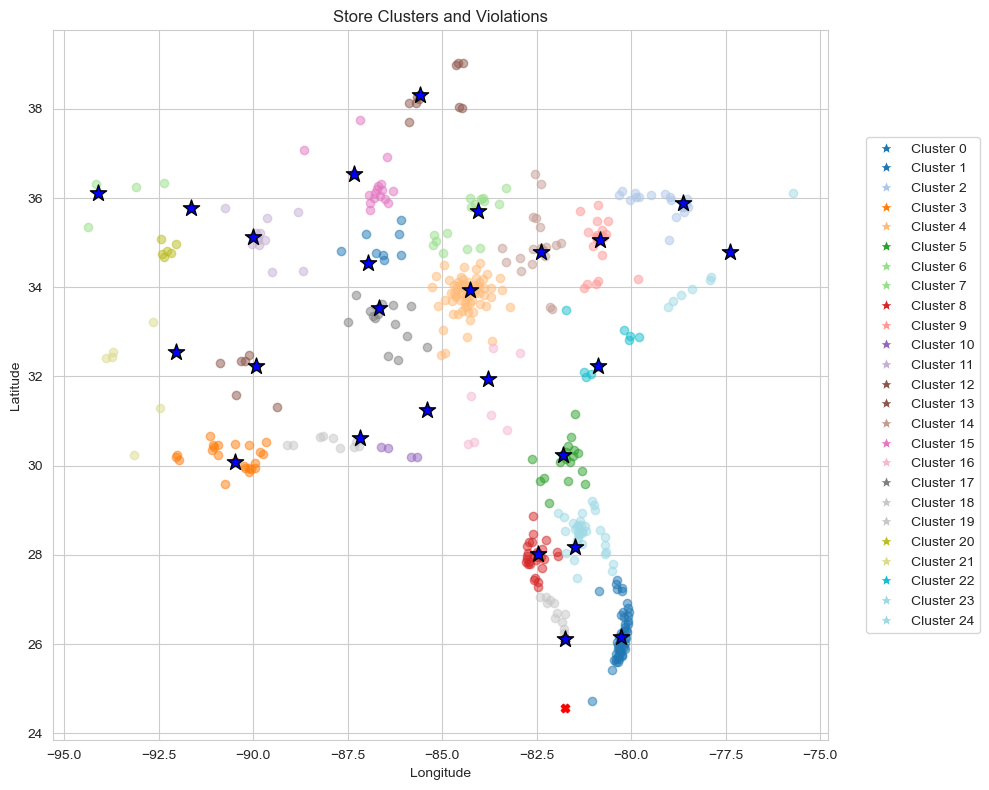

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define colormap for clusters and color/marker for hubs and violations
colormap = plt.cm.get_cmap('tab20', len(final_network['Clusters']))  # Ensures unique colors for each cluster
violation_color = 'red'
violation_marker = 'X'
hub_marker = '*'
hub_color = 'blue'

# Create the base plot for stores and clusters
plt.figure(figsize=(10, 8))

# Create a list to store the handles and labels for the legend
legend_handles = []

# Plot the clusters with unique colors and markers
for cluster_id, cluster_data in final_network['Clusters'].items():
    # Get a unique color for the current cluster
    cluster_color = colormap(cluster_id)  # Use a unique color from the colormap

    # Plot each route in the cluster
    for route in cluster_data['Routes']:
        # Plot each location in the route
        for location in route['Route']:
            store_location = store_data[store_data['location'] == location]
            plt.scatter(store_location['longitude'], store_location['latitude'], 
                        c=[cluster_color] * len(store_location), marker='o', alpha=0.5)

    # Plot the hub as a star on top of the cluster
    hub_location = store_data[store_data['location'] == cluster_data['Hub']]
    hub_handle = plt.scatter(hub_location['longitude'], hub_location['latitude'], 
                             c=hub_color, marker=hub_marker, s=150, edgecolors='black', zorder=5)
    legend_handles.append(hub_handle)

# Plot violations (routes exceeding max distance)
for violation in violations:
    # Find the route that has the violation
    for location in violation['Route']:
        store_location = store_data[store_data['location'] == location]
        plt.scatter(store_location['longitude'], store_location['latitude'], 
                    c=violation_color, marker=violation_marker, label=f"Violation: {violation['Route Name']}")

# Set up the rest of the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Store Clusters and Violations')

# Add a legend for clusters only (no stores or violations)
cluster_labels = [f"Cluster {cluster_id}" for cluster_id in final_network['Clusters']]
cluster_handles = [plt.Line2D([0], [0], marker=hub_marker, color='w', markerfacecolor=colormap(cluster_id), 
                              markersize=10, label=label) for cluster_id, label in enumerate(cluster_labels)]
plt.legend(handles=cluster_handles + legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Show the plot with adjustments
plt.tight_layout()
plt.show()


This block will create graphs of every hub and its routes.
NOTE: The routes shown are the order it should be done in, but since the graph uses latitude and longitude and connects the points directly, the actaul routes will follow roads

C:\Users\newsf\AppData\Local\Temp\ipykernel_14044\549374581.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(final_network['Clusters']))  # 'tab20' colormap has 20 distinct colors


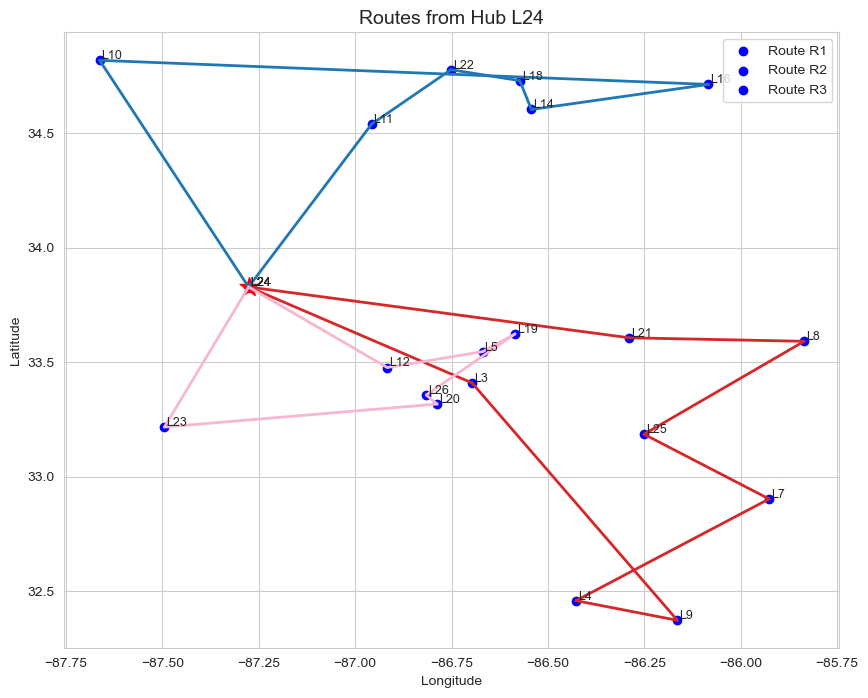

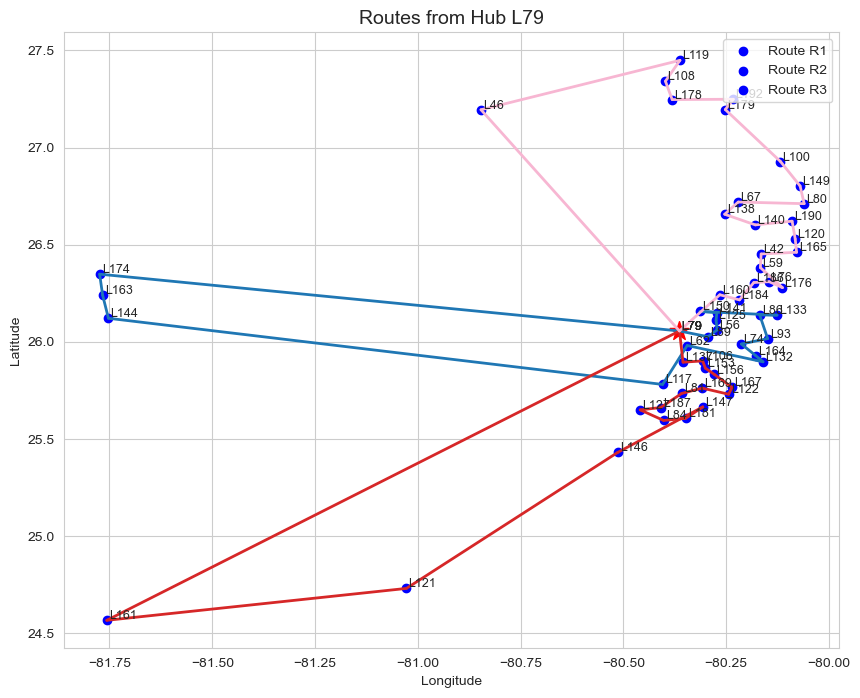

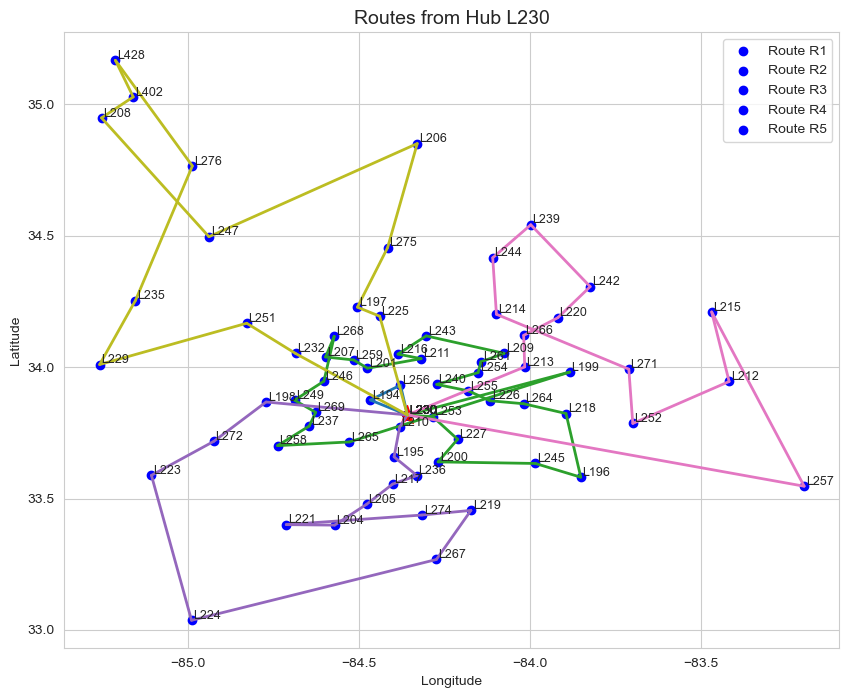

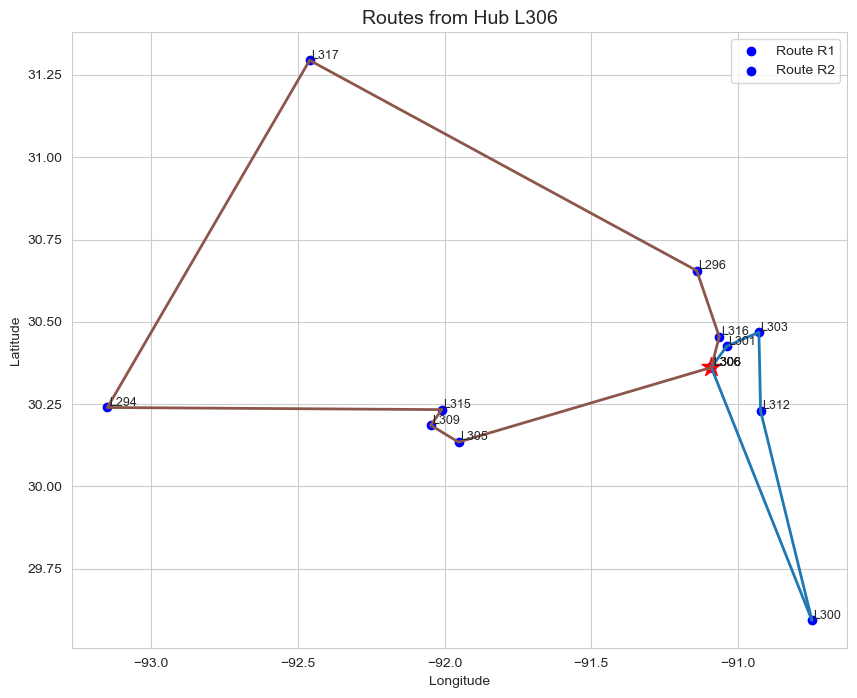

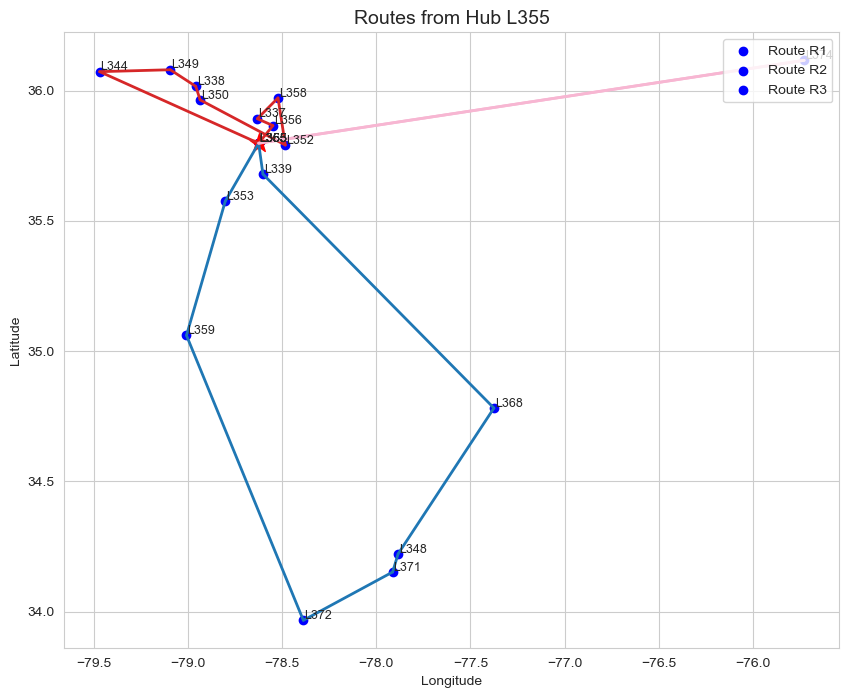

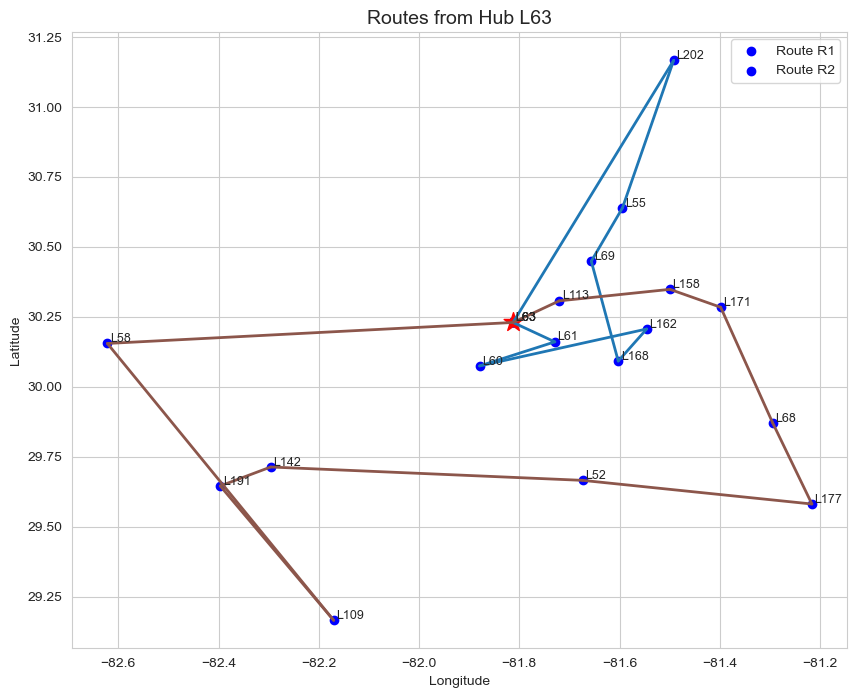

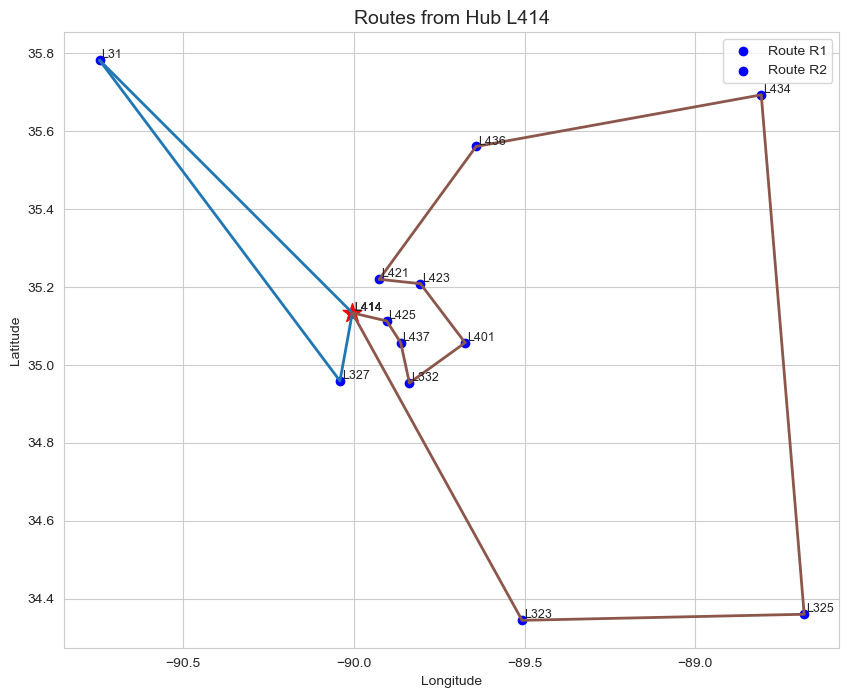

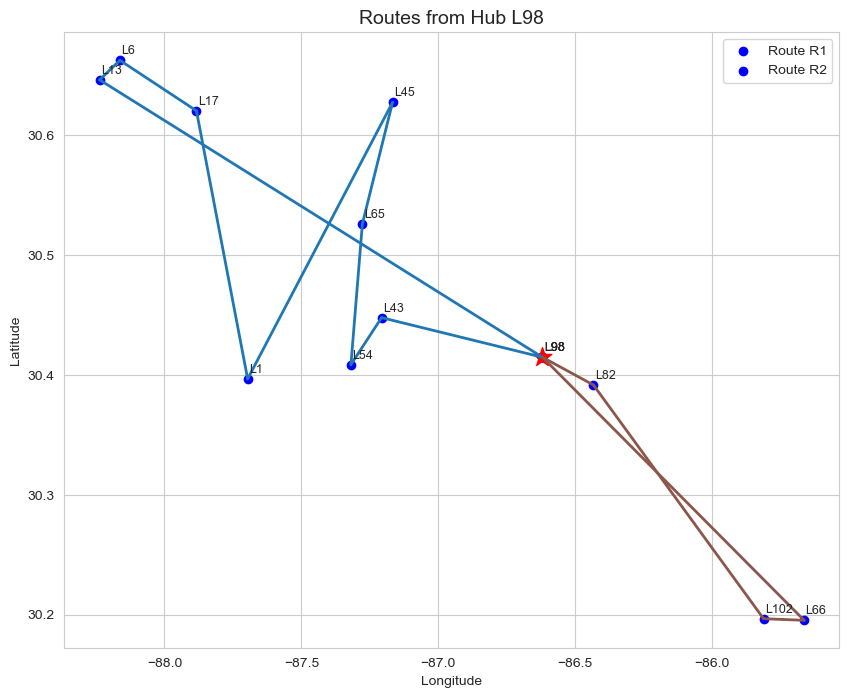

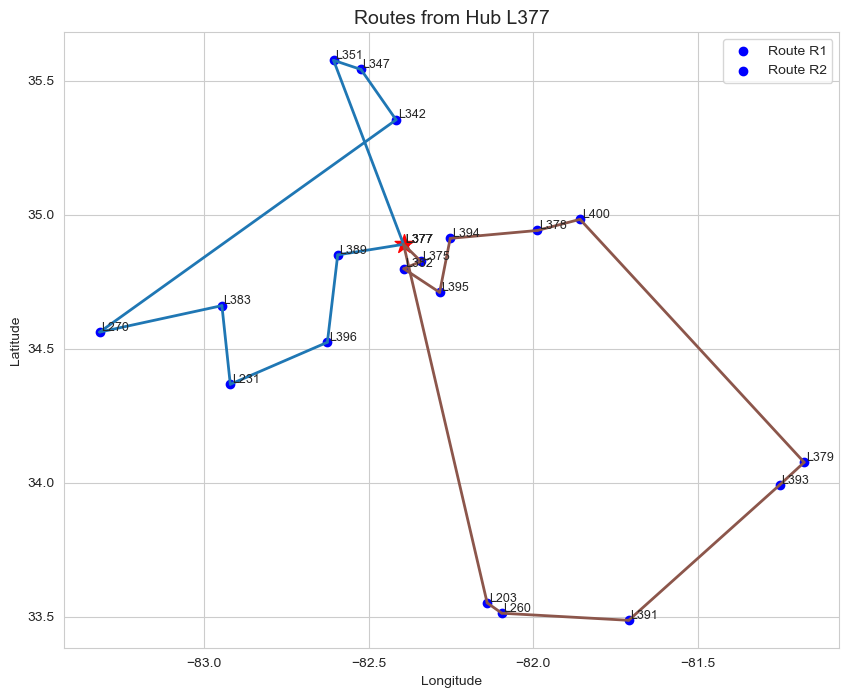

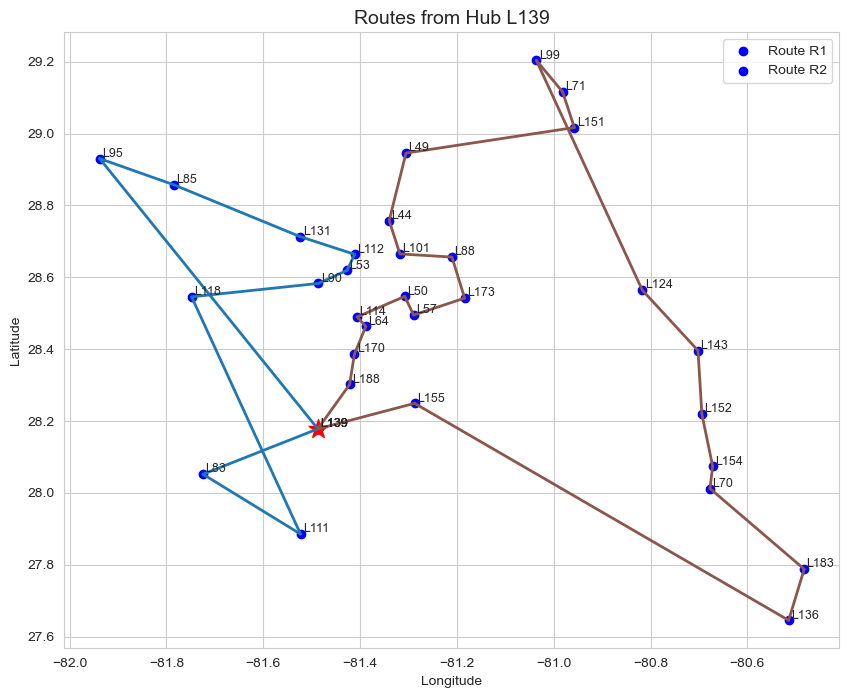

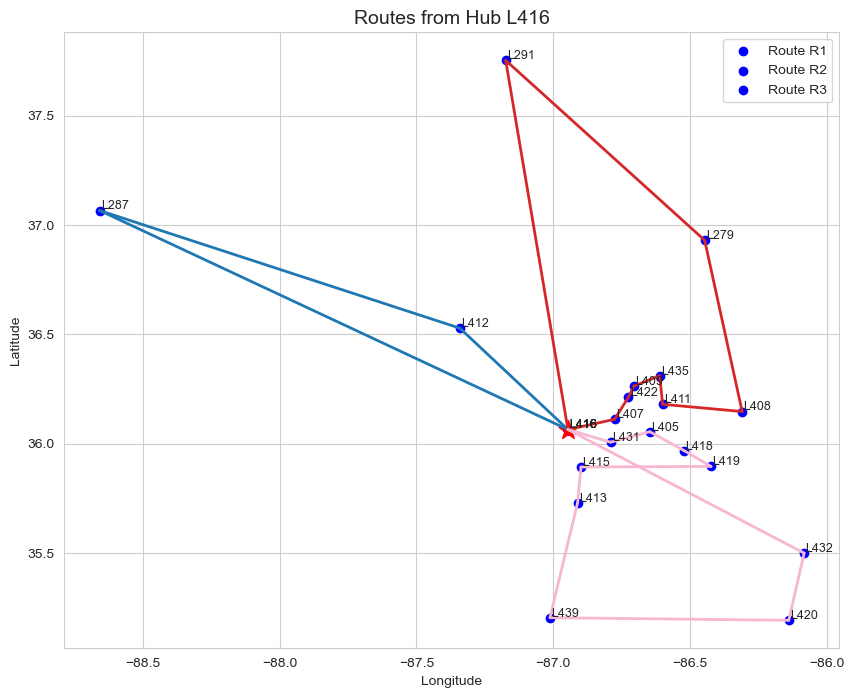

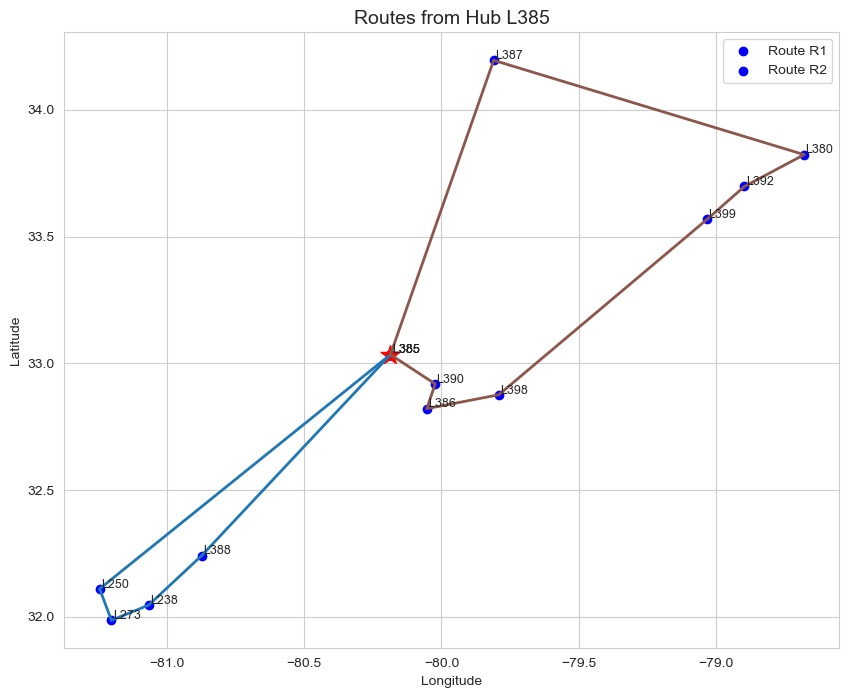

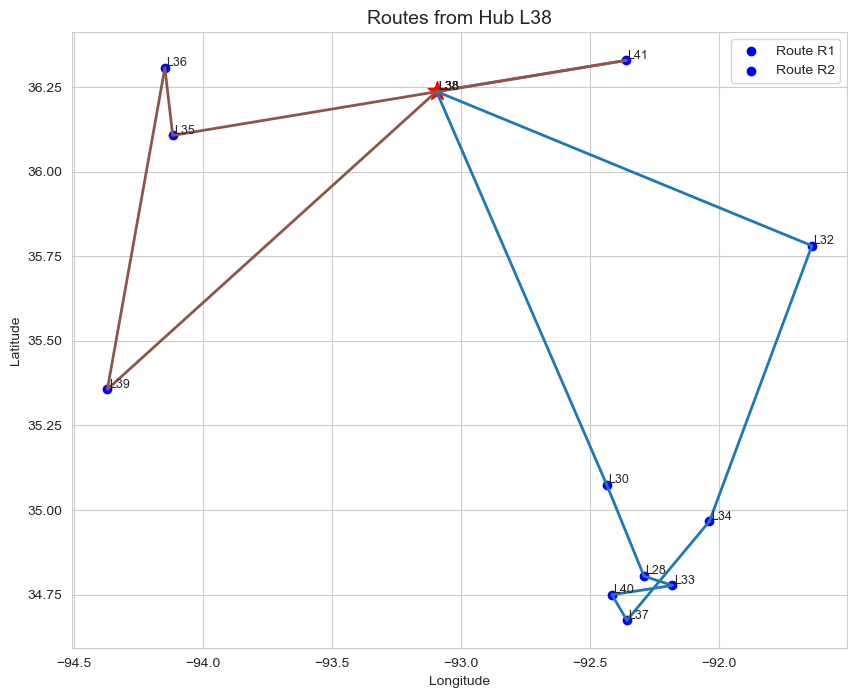

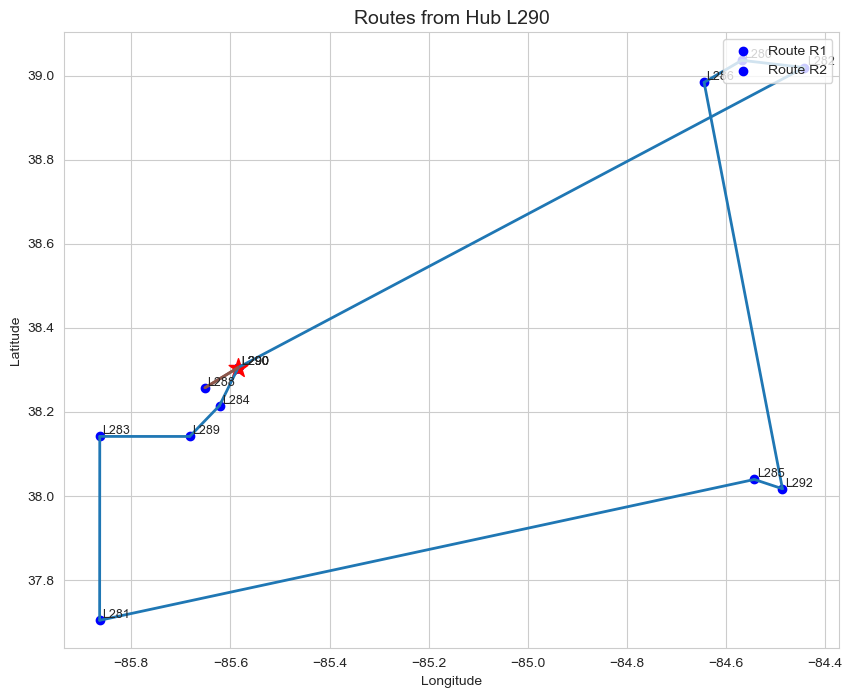

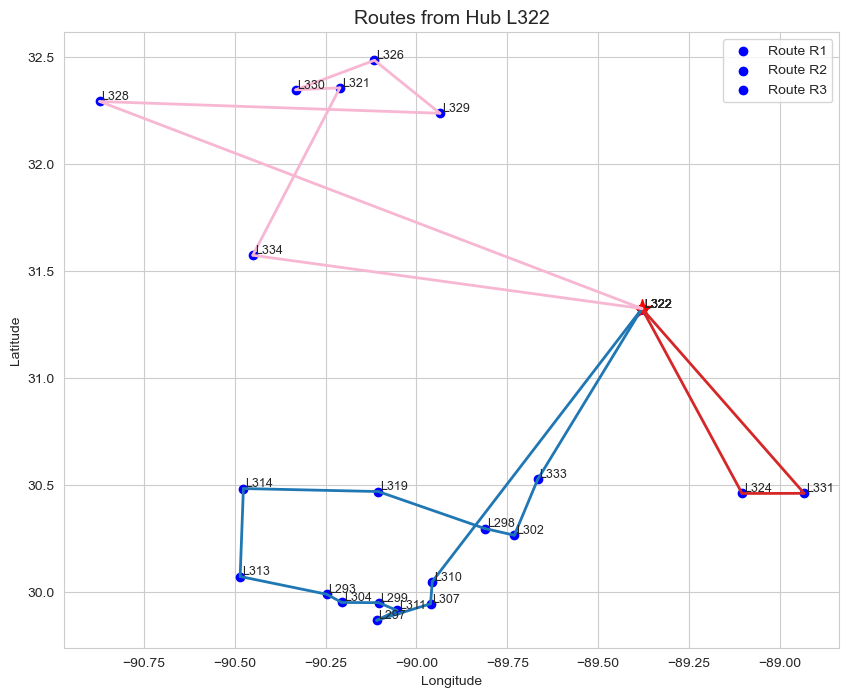

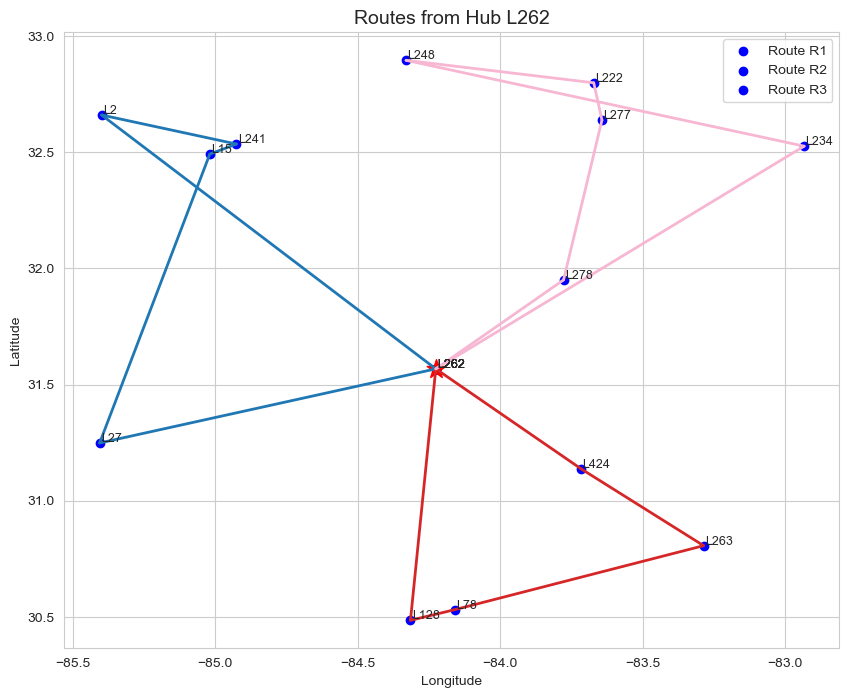

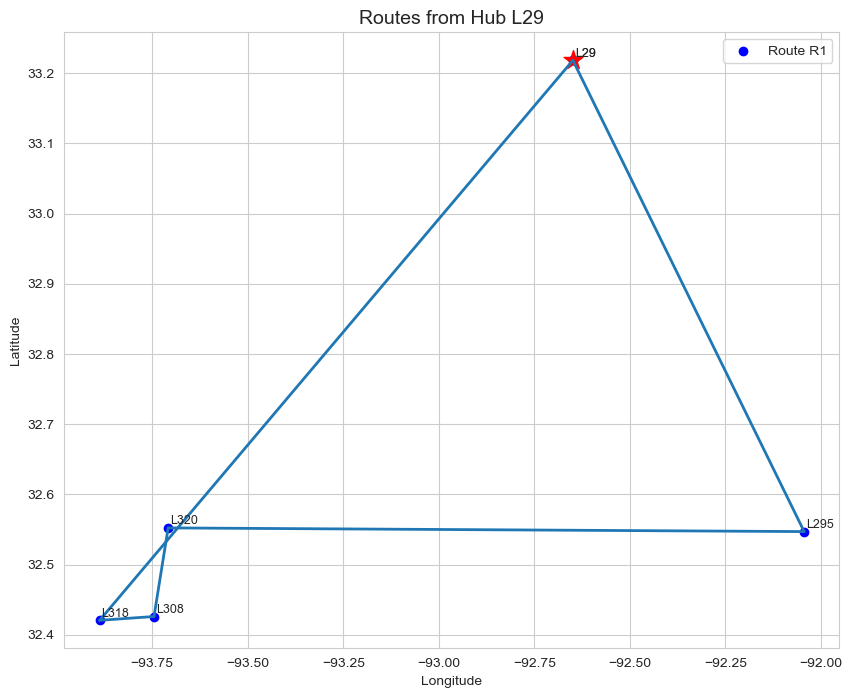

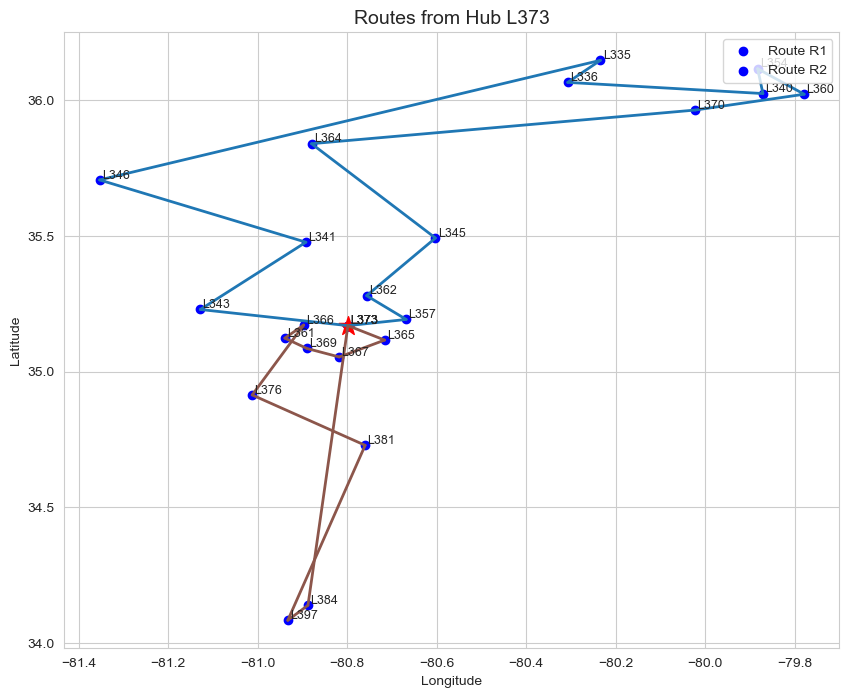

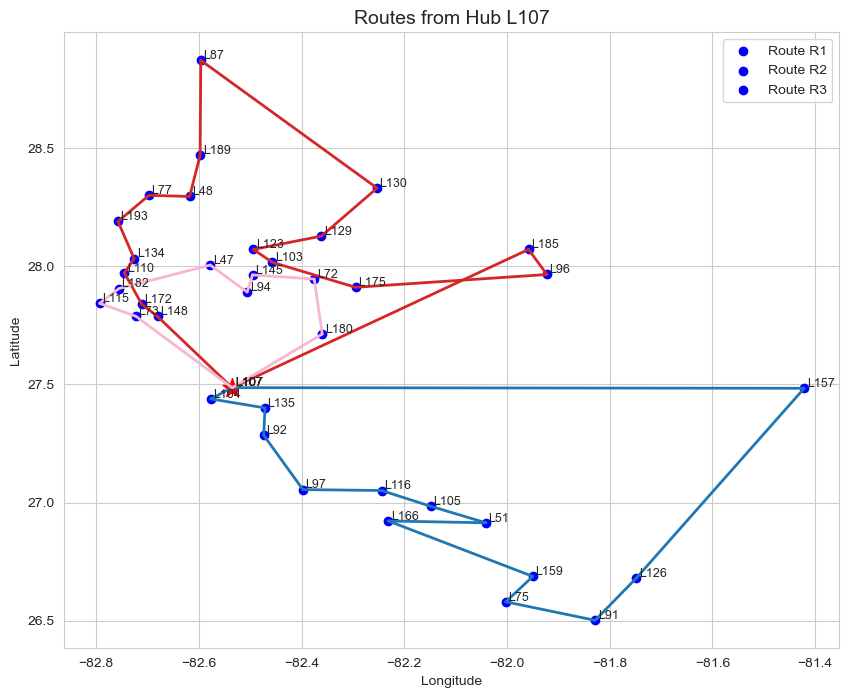

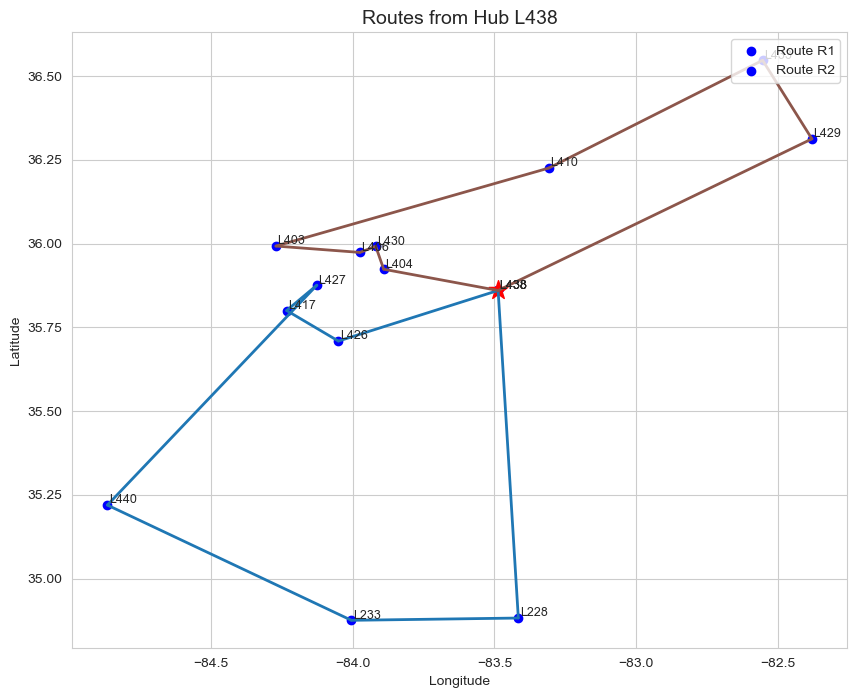

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a list of colors for each route (ensure there are enough colors)
colors = plt.cm.get_cmap('tab20', len(final_network['Clusters']))  # 'tab20' colormap has 20 distinct colors

# Iterate through clusters in final_network to create scatter plots
for cluster_id, cluster_data in final_network['Clusters'].items():
    # Extract the hub location for the current cluster
    hub = cluster_data['Hub']
    hub_location = store_data[store_data['location'] == hub].iloc[0][['latitude', 'longitude']]
    
    # Create a list of store locations for the current cluster
    store_locations = []
    for route in cluster_data['Routes']:
        for location in route['Route']:
            # Find the latitude and longitude for each store in the route
            store_location = store_data[store_data['location'] == location].iloc[0][['latitude', 'longitude']]
            store_locations.append((location, store_location))

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    # Plot the store locations as dots and annotate them with their names
    for location, store_location in store_locations:
        plt.scatter(store_location['longitude'], store_location['latitude'], color='blue', marker='o')
        plt.text(store_location['longitude'] + 0.005, store_location['latitude'] + 0.005, location, fontsize=9, ha='left')

    # Plot the hub location as a star
    plt.scatter(hub_location['longitude'], hub_location['latitude'], color='red', marker='*', s=200)

    # Iterate through the routes to plot them with different colors
    route_labels = []  # To store labels for the legend
    for route_idx, route in enumerate(cluster_data['Routes']):
        route_color = colors(route_idx / len(cluster_data['Routes']))  # Ensure the color is within the range
        route_label = f"Route {route['Route Name']}"
        route_labels.append(route_label)
        for i in range(1, len(route['Route'])):
            start_location = store_data[store_data['location'] == route['Route'][i-1]].iloc[0][['latitude', 'longitude']]
            end_location = store_data[store_data['location'] == route['Route'][i]].iloc[0][['latitude', 'longitude']]
            plt.plot([start_location['longitude'], end_location['longitude']], 
                     [start_location['latitude'], end_location['latitude']], color=route_color, linestyle='-', linewidth=2)

    # Set the plot title
    cluster_number = str(cluster_id + 1)  # Convert to string for concatenation
    plt.title(f"Routes from Hub {hub}", fontsize=14)  # Adjusted title format

    # Set axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a legend for routes (excluding the hub)
    plt.legend(route_labels, loc='upper right')

    # Show the plot
    plt.grid(True)
    plt.show()


This block graphcially (messily) shows all valid routes

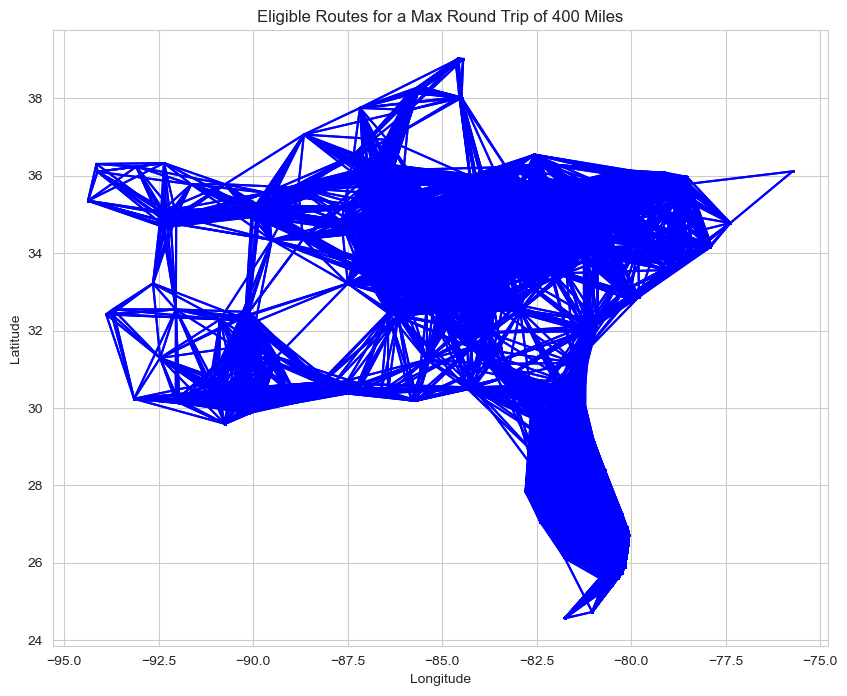

In [ ]:
# Valid Routes
max_distance = 400
# Filter for valid routes with distance less than 200 miles
plot_routes = road_distances[road_distances['distance'] < max_distance/2]
graph_store_data = store_data.set_index('location')

# Create a plot for the routes
plt.figure(figsize=(10, 8))  # Set a proper size for your map

for i in plot_routes.index:
    # Extract location_1 and location_2 for each valid route
    location_1 = plot_routes.loc[i, 'store1']
    location_2 = plot_routes.loc[i, 'store2']

    # Check if both locations exist in store_data
    if location_1 in graph_store_data.index and location_2 in graph_store_data.index:
        if location_1 != location_2:
            # Extract the coordinates for the locations
            lon1, lat1 = graph_store_data.loc[location_1, ['longitude', 'latitude']]
            lon2, lat2 = graph_store_data.loc[location_2, ['longitude', 'latitude']]

            # Plot the line connecting the points (use plt.plot instead of sns.lineplot)
            plt.plot([lon1, lon2], [lat1, lat2], marker='o', markersize=1, linestyle='-', color='b')
    else:
        print(f"Warning: One or both locations ({location_1}, {location_2}) are not found in store_data.")

# Set the title and labels for the plot
plt.title("Eligible Routes for a Max Round Trip of 400 Miles")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()



<p style="text-align:center; font-weight:bold;">LEGACY CODE:</p> 
This code is no longer relevant, but it has been kept in because it was used at one point.

In [ ]:
graph_data=store_data.loc[selected_hubs]

plt.figure(figsize=(8, 6))

# Plot graph_data with a blue color and circle markers
plt.scatter(store_data['longitude'], store_data['latitude'], color='blue', marker='o', label='Store Locations')

# Plot job_data with a red color and square markers
plt.scatter(graph_data['longitude'], graph_data['latitude'], color='red', marker='s', label='Hub Locations')

# Add labels and title
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Graph of Hub and Store Locations')

# Show legend to distinguish between graph_data and job_data
plt.legend()

# Show the plot
plt.show()

In [ ]:
def hub_selection(screening_distance, all_routes):

    valid_routes = valid_route_selector(screening_distance, all_routes)

    selected_hubs = []  # List to store the selected hubs
    hub_routes_dict = {}  # Dictionary to store the selected hub routes dynamically

    while not valid_routes.empty:
        
        location_counts = valid_routes['location_1'].value_counts()
        location_counts_list = [(location, count) for location, count in location_counts.items()]
        
        for location, count in location_counts_list:
            # Select routes for the current location with haversine distance <= screening distance
            selected_hub_routes = valid_routes[(valid_routes['location_1'] == location) & 
                                                (valid_routes['haversine_distance'] <= screening_distance)]

            # Store the selected hub's routes in the dictionary with the location as the key
            hub_routes_dict[location] = selected_hub_routes
            selected_hubs.append(location)

            # Remove all routes involving the selected hub, either as location_1 or location_2
            valid_routes = valid_routes[~valid_routes['location_1'].isin([location]) & 
                                         ~valid_routes['location_2'].isin([location])]
            
            # Remove all locations that are served by the selected hub
            for destination in selected_hub_routes['location_2']:  # Get all destinations for this hub
                valid_routes = valid_routes[~valid_routes['location_1'].isin([location]) & 
                                             ~valid_routes['location_2'].isin([destination])]

            break  # Exit the for loop to start the next iteration

    # Return selected hubs and the dictionary of hub routes
    return selected_hubs, hub_routes_dict
